**Наумов Герман**

In [ ]:
!pip install -U sentence-transformers

In [2]:
import pandas as pd
import numpy as np
import re
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import seaborn as sns
from gensim.models import Word2Vec, FastText
from collections import Counter
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
df = pd.read_csv('/content/socialmedia_relevant_cols.csv', encoding='windows-1251')
df.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


В нашем датасете есть 2 очень похожих столбца, я решил проверить, насколько они похожи. В случае идентичности - убрать один из них

In [4]:
dict_map = {"Relevant": 1, "Not Relevant": 0, "Can't Decide": 2}
sum(df['choose_one'].map(dict_map) == df['class_label']) == df.shape[0]

True

In [5]:
df.drop(columns='choose_one', inplace=True)

In [6]:
df['class_label'].value_counts()

class_label
0    6187
1    4673
2      16
Name: count, dtype: int64

Так как в тз написано, что всего <ins> два класса</ins>: катастрофа или нет; а в нашем датасете их 3, я решил убрать класс - Can't decide

In [7]:
to_del_ind = df[df['class_label'] == 2].index
df.drop(index=to_del_ind, inplace=True)

#1
Нам необходимо убрать лишние символы, стоп-слова.


In [8]:
unqs = set()
for i in df['text'].astype(str):
  unqs.update(i)
ls = list(unqs)
elems_to_del = [x for x in ls if not x.isalpha()]
print(sorted(elems_to_del))

['\n', '\r', ' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '©', '—', '’', '‚', '“', '”', '…']


Теперь в elems_to_del у меня символы - не буквы. Их я удалю.
Также в твиттах остались цифры. Скорее всего, они обозначают время, дистанцию до происшествия, количество жертв и тд. На всякий случай я удалю их тоже, хотя их можно перевести в буквенное представление

In [9]:
import nltk
tokenizer = WordPunctTokenizer()
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def cleaner(text, elems_to_del):
  text = text.lower()
  text = text.replace('http://t.co/', '')
  text = text.replace('http', '')
  text = text.replace('www', '')
  text = text.replace('https', '')
  text_tokenized = tokenizer.tokenize(text)

  ans = [word for word in text_tokenized if word not in stop_words and word not in elems_to_del and word.isalpha()]

  return ' '.join(ans)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
print('Было:')
print(df['text'].head(10).values)
print('Стало:')
print(df['text'].apply(lambda x: cleaner(x, elems_to_del)).head(10).values)

Было:
['Just happened a terrible car crash'
 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Heard about #earthquake is different cities, stay safe everyone.'
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'
 'Apocalypse lighting. #Spokane #wildfires']
Стало:
['happened terrible car crash'
 'deeds reason earthquake may allah forgive us'
 'heard earthquake different cities stay safe everyone'
 'forest fire spot pond geese fleeing across street cannot save'
 'forest 

In [11]:
df['text'] = df['text'].apply(lambda x: cleaner(x, elems_to_del))

#2
Проводим EDA

Посмотрим на статистику, какие у нас вообще твитты есть, какой они длины

In [12]:
data = pd.Series([len(text.split()) for text in df['text'].astype(str)], index=df.index, name='num_words')
data.describe()

count    10860.000000
mean         9.087017
std          3.552415
min          0.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         23.000000
Name: num_words, dtype: float64

<Axes: xlabel='num_words'>

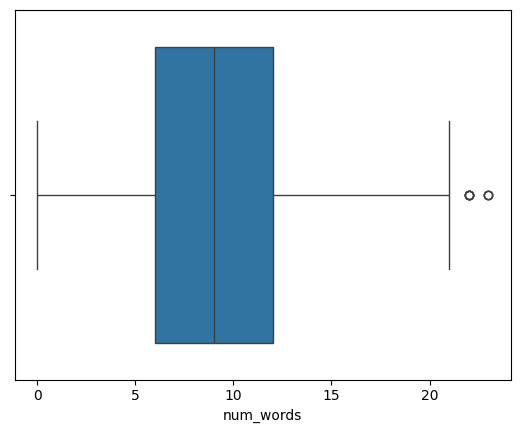

In [13]:
sns.boxplot(x=data)

Заметим, что есть твиты, из которого мы убрали все символы, удалим их

In [14]:
bad_ind = data[data == 0].index
bad_ind.to_list()
df.drop(index=bad_ind, inplace=True)
data.drop(index=bad_ind, inplace=True)

Посмотрим, влияет ли как то размер твитта на метку класса

<ipython-input-15-551133da9f5d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df1, x='num_words', y='label', orient='h', palette='rocket')


<Axes: xlabel='num_words', ylabel='label'>

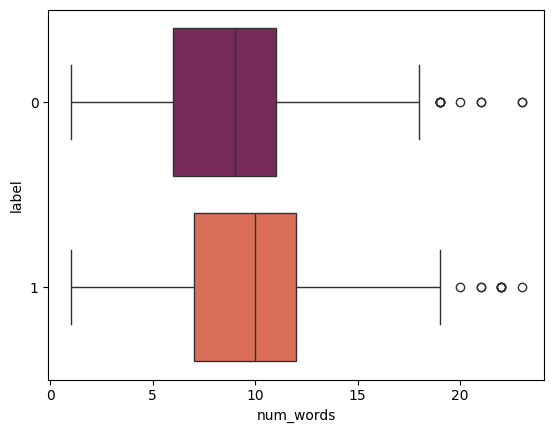

In [15]:
df1 = pd.DataFrame(data)
df1['label'] = df['class_label']
sns.boxplot(data=df1, x='num_words', y='label', orient='h', palette='rocket')

Посмотрим, есть ли какие то слова, которые сразу помогут понять, что нужно поставить метку 1 или 0

In [16]:
first = Counter(' '.join(df[df['class_label'] == 1]['text']).split())
zero = Counter(' '.join(df[df['class_label'] == 0]['text']).split())
d1 = dict(first.most_common(6))
d0 = dict(zero.most_common(6))

[Text(0.5, 1.0, 'Самые популярные слова в твите о катастрофе')]

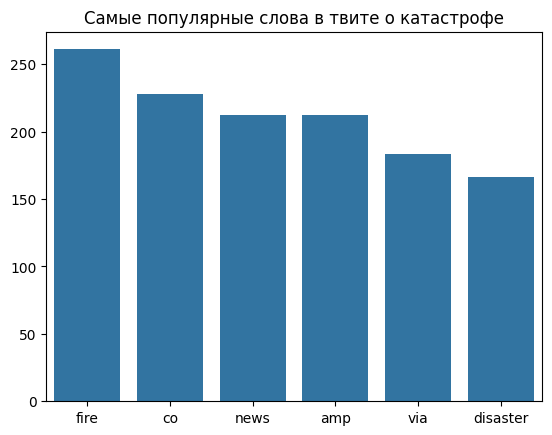

In [17]:
sns.barplot(d1).set(title='Самые популярные слова в твите о катастрофе')

[Text(0.5, 1.0, 'Самые популярные слова в обычном твите')]

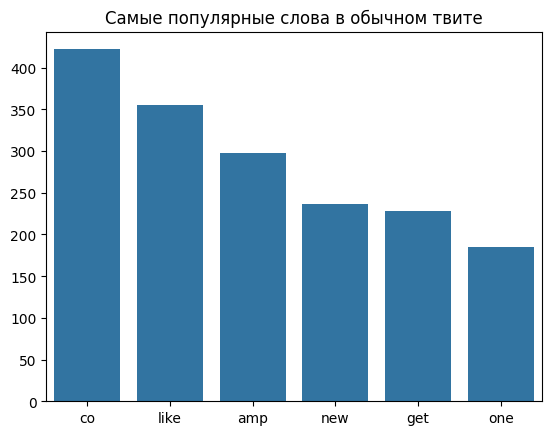

In [18]:
sns.barplot(d0).set(title='Самые популярные слова в обычном твите')

#3
Токенизация

## По словам

**Идея**
<br> Тут используется WordPunctTokenizer - это усовершенствованная версия простого токенайзера. Разбивает на отдельные элементы слова и пунктуацию

In [19]:
tokenizer = WordPunctTokenizer()

In [20]:
df_token_words = df.copy()

In [21]:
def text_to_tokens(text):
  text_tokenized = tokenizer.tokenize(text)
  return text_tokenized

df_token_words['tokens'] = df_token_words['text'].apply(lambda x: text_to_tokens(x))

In [22]:
df_token_words

,text,class_label,tokens
0,happened terrible car crash,1,"[happened, terrible, car, crash]"
1,deeds reason earthquake may allah forgive us,1,"[deeds, reason, earthquake, may, allah, forgiv..."
2,heard earthquake different cities stay safe ev...,1,"[heard, earthquake, different, cities, stay, s..."
3,forest fire spot pond geese fleeing across str...,1,"[forest, fire, spot, pond, geese, fleeing, acr..."
4,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]"
...,...,...,...
10871,utc volcano hawaii,1,"[utc, volcano, hawaii]"
10872,police investigating e bike collided car littl...,1,"[police, investigating, e, bike, collided, car..."
10873,latest homes razed northern california wildfir...,1,"[latest, homes, razed, northern, california, w..."
10874,meg issues hazardous weather outlook hwo,1,"[meg, issues, hazardous, weather, outlook, hwo]"


## BPE

**Идея**
<br> Допустим у нас есть словарь и текст, который нужно токенизировать. Мы пройдемся по тексту, найдем такую комбинацию символов, которая встречается чаще всего и добавим ее в наш словарь. Теперь мы будем искать такую комбинацию 2х символов или комбинацию символа+комбинации, которая встречается чаще всего, также добавим это в словарь. И так далее
<br> Наверно, это можно назвать - рекурсивным поиском комбинаций(подстрок)

In [23]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

In [24]:
df_token_bpe = df.copy()

In [25]:
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
trainer = trainers.BpeTrainer(vocab_size=100, min_frequency=2)
tokenizer.train_from_iterator(df_token_bpe['text'].tolist(), trainer)

def tokenize_text(text):
    encoded = tokenizer.encode(text)
    return encoded.tokens

df_token_bpe['tokens'] = df_token_bpe['text'].apply(tokenize_text)

In [26]:
df_token_bpe

,text,class_label,tokens
0,happened terrible car crash,1,"[h, ap, p, en, ed, ter, ri, b, le, c, ar, c, r..."
1,deeds reason earthquake may allah forgive us,1,"[de, ed, s, re, as, on, e, ar, th, q, u, a, ke..."
2,heard earthquake different cities stay safe ev...,1,"[h, e, ar, d, e, ar, th, q, u, a, ke, d, i, f,..."
3,forest fire spot pond geese fleeing across str...,1,"[f, o, re, st, fi, re, s, p, ot, p, on, d, ge,..."
4,forest fire near la ronge sask canada,1,"[f, o, re, st, fi, re, ne, ar, la, r, on, ge, ..."
...,...,...,...
10871,utc volcano hawaii,1,"[u, t, c, v, ol, c, an, o, h, a, w, a, i, i]"
10872,police investigating e bike collided car littl...,1,"[p, o, li, c, e, in, ve, st, i, g, at, ing, e,..."
10873,latest homes razed northern california wildfir...,1,"[l, at, e, st, h, om, es, ra, z, ed, n, or, th..."
10874,meg issues hazardous weather outlook hwo,1,"[m, e, g, is, s, u, es, h, a, z, ar, d, ou, s,..."


## Berttokenizer

**Идея**
<br> Этот токенизатор использует идею Wordpiece. Wordpiece строит свой словарь похожим образом как и BPE, но в этом методе нам не все равно на положение комбинации в строке:
<br> Если слово не начинается с компбинации, то комб обозначается как ##combination
<br> Если слово начинается с комбинации, то комб обозначается как combination (без решеток)

In [27]:
from transformers import BertTokenizer

In [28]:
df_token_bert = df.copy()

In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [30]:
def tokenize_text(text):
    encoded = tokenizer.tokenize(text)
    return encoded
df_token_bert['tokens'] = df_token_bert['text'].apply(tokenize_text)

In [31]:
df_token_bert

,text,class_label,tokens
0,happened terrible car crash,1,"[happened, terrible, car, crash]"
1,deeds reason earthquake may allah forgive us,1,"[deeds, reason, earthquake, may, allah, forgiv..."
2,heard earthquake different cities stay safe ev...,1,"[heard, earthquake, different, cities, stay, s..."
3,forest fire spot pond geese fleeing across str...,1,"[forest, fire, spot, pond, geese, fleeing, acr..."
4,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ron, ##ge, sas, ##k, ..."
...,...,...,...
10871,utc volcano hawaii,1,"[utc, volcano, hawaii]"
10872,police investigating e bike collided car littl...,1,"[police, investigating, e, bike, collided, car..."
10873,latest homes razed northern california wildfir...,1,"[latest, homes, ra, ##zed, northern, californi..."
10874,meg issues hazardous weather outlook hwo,1,"[meg, issues, hazardous, weather, outlook, h, ..."


# 4



## Векторизация

**Идея**
<br> TF-IdF метод, позволяющий находить в документе важные слова, отражающие смысл документа.
<br> Состоит из двух множителей:
<br> TF - сколько раз слово встретилось в документе/ кол-во слов в документе
<br> IdF - log ( кол-во документов всего / кол-во документов с этим словом)

In [32]:
df_vect = df.copy()

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
vectorizer = TfidfVectorizer()
tfidf_matr = vectorizer.fit_transform(df_vect['text'])
tfidf = pd.DataFrame(tfidf_matr.toarray(), columns=vectorizer.get_feature_names_out(), index=df_vect.index)

In [35]:
tfidf

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aaffndcdnq,aahyoeitzl,aan,aannnnd,aapatwork,...,оћmgn,цekdar,щp,ьў,ќmy,ќyeah,ўi,ўif,ўthis,ўоѕ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Можно сделать конкатенацию <br>df_copy_vect = pd.concat([df_copy_vect, tfidf], axis=1) <br>но у меня это, съедает много оперативы(

Убедимся, что хоть где-то tf-idf > 0.
<br> Для предложения из первой строки 'happened terrible car crash' получимм такие значения

In [36]:
q = tfidf.iloc[0]
q[q>0]

car         0.428903
crash       0.413219
happened    0.537414
terrible    0.597059
Name: 0, dtype: float64

## FastText

**Идея**
<br> Как и в Word2Vec есть разные подходы. Skip-gram (предсказываем слово по контексту) и Cbow (наоборот). Но алгоритм считает, что у нас вместо слов n-граммы. Получив эмбеддинги для разных значений n, усредняет и получает итоговый.
<br> Такой подход получше взаимодействует с редкими словами, сленгом. Возможно, он получше будет работать с нашими твиттами.

In [37]:
df_embed1 = df_token_words.copy()

In [61]:
model = FastText(sentences=df_embed1['tokens'], vector_size=300, window=3, min_count=1, workers=4).wv

In [62]:
def create_text_emb(text, model):
  ls = [model.get_vector(word) for word in text]
  return list(np.sum(ls, axis=0))
df_embed1['FT'] = df_embed1['tokens'].apply(lambda x: create_text_emb(x, model))

In [40]:
df_embed1

,text,class_label,tokens,FT
0,happened terrible car crash,1,"[happened, terrible, car, crash]","[-0.4112395, 2.4059014, -1.9166574, -0.1965311..."
1,deeds reason earthquake may allah forgive us,1,"[deeds, reason, earthquake, may, allah, forgiv...","[-0.5962665, 3.5320954, -2.8137946, -0.2885762..."
2,heard earthquake different cities stay safe ev...,1,"[heard, earthquake, different, cities, stay, s...","[-0.5696157, 3.3639944, -2.6760185, -0.2765245..."
3,forest fire spot pond geese fleeing across str...,1,"[forest, fire, spot, pond, geese, fleeing, acr...","[-0.82887506, 4.8780704, -3.8864148, -0.399481..."
4,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[-0.608491, 3.5815897, -2.852058, -0.29055065,..."
...,...,...,...,...
10871,utc volcano hawaii,1,"[utc, volcano, hawaii]","[-0.06872564, 0.40854543, -0.3266342, -0.03211..."
10872,police investigating e bike collided car littl...,1,"[police, investigating, e, bike, collided, car...","[-1.4010675, 8.249442, -6.5762935, -0.6668915,..."
10873,latest homes razed northern california wildfir...,1,"[latest, homes, razed, northern, california, w...","[-0.7605247, 4.4808216, -3.5734742, -0.3648973..."
10874,meg issues hazardous weather outlook hwo,1,"[meg, issues, hazardous, weather, outlook, hwo]","[-0.34273666, 2.0231924, -1.6098831, -0.161816..."


## С Hugginface

**Идея**
<br> Берем предобученные эмбеддинги полученные от модели JinaBERT

In [41]:
df_embed2 = df_token_words.copy()

In [42]:
model = SentenceTransformer(
    "jinaai/jina-embeddings-v2-base-en",
    trust_remote_code=True
)
embeds = model.encode(df_embed2['text'].to_list(), batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/340 [00:00<?, ?it/s]

In [43]:
df_embed2['HF'] = embeds.tolist()

In [44]:
df_embed2

,text,class_label,tokens,HF
0,happened terrible car crash,1,"[happened, terrible, car, crash]","[-0.47261548042297363, -0.5244330167770386, 0...."
1,deeds reason earthquake may allah forgive us,1,"[deeds, reason, earthquake, may, allah, forgiv...","[-0.23591971397399902, -0.9669387340545654, 0...."
2,heard earthquake different cities stay safe ev...,1,"[heard, earthquake, different, cities, stay, s...","[-0.12491287291049957, -0.4994921088218689, 0...."
3,forest fire spot pond geese fleeing across str...,1,"[forest, fire, spot, pond, geese, fleeing, acr...","[-0.03518051654100418, -0.583051323890686, 0.3..."
4,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[0.5566437840461731, -0.37826529145240784, 0.3..."
...,...,...,...,...
10871,utc volcano hawaii,1,"[utc, volcano, hawaii]","[0.1213802844285965, -0.9765990972518921, 0.65..."
10872,police investigating e bike collided car littl...,1,"[police, investigating, e, bike, collided, car...","[-0.47605571150779724, -0.2642960846424103, 0...."
10873,latest homes razed northern california wildfir...,1,"[latest, homes, razed, northern, california, w...","[-0.3359220027923584, -0.8079306483268738, 0.2..."
10874,meg issues hazardous weather outlook hwo,1,"[meg, issues, hazardous, weather, outlook, hwo]","[0.0764855295419693, -0.4232654273509979, 0.82..."


# 5

In [63]:
df_FT = df_embed1.copy()
df_FT.drop(['text', 'tokens'], axis=1,inplace=True)

In [64]:
embeds = np.array(df_FT['FT'].tolist())
pcaed = PCA(n_components=2)
comprd = pcaed.fit_transform(embeds)
df_FT['PCA_1'] = comprd[:, 1]
df_FT['PCA_2'] = comprd[:, 0]

<Axes: xlabel='PCA_1', ylabel='PCA_2'>

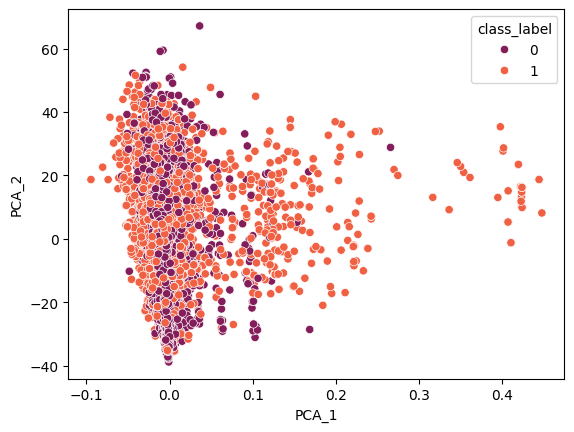

In [65]:
sns.scatterplot(x='PCA_1', y='PCA_2', hue='class_label', data=df_FT, palette='rocket')

In [48]:
df_hf = df_embed2.copy()
df_hf.drop(['text', 'tokens'], axis=1,inplace=True)

In [49]:
embeds = np.array(df_hf['HF'].tolist())
pcaed = PCA(n_components=2)
comprd = pcaed.fit_transform(embeds)
df_hf['PCA_1'] = comprd[:, 0]
df_hf['PCA_2'] = comprd[:, 1]

<Axes: xlabel='PCA_1', ylabel='PCA_2'>

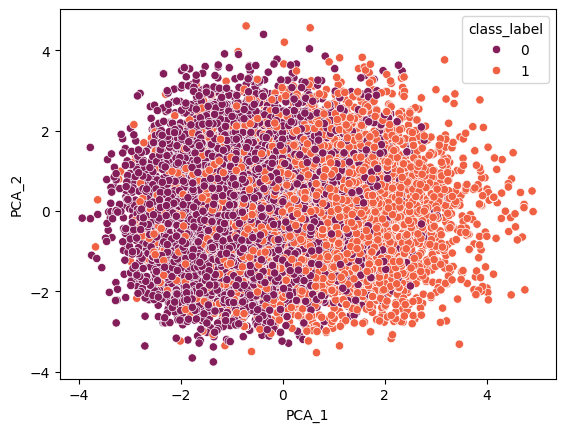

In [50]:
sns.scatterplot(x='PCA_1', y='PCA_2', hue='class_label', data=df_hf, palette='rocket')